In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

2024-03-07 12:18:40.875357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
def stitch_images_to_grid(image_paths, grid_shape=(3, 2)):
    # Assuming all images have the same dimensions
    sample_img = Image.open(image_paths[0])
    img_width, img_height = sample_img.size
    
    # Determine the grid's total size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]
    
    # Create an empty array for the grid
    grid_array = np.zeros((grid_height, grid_width), dtype=np.uint16)
    
    # Load and place each image into the grid array
    for index, img_path in enumerate(image_paths):
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        # Load the image and convert to numpy array
        img = Image.open(img_path)
        img_array = np.array(img)
        # Place the image in the correct position
        grid_array[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = img_array
    
    return grid_array

In [15]:
# Example usage for a specific channel
channel = 'Hoechst'
channel_dir = os.path.join(base_dir, f'{channel}/24277-{channel}')
processed_images = load_and_preprocess_imgs(channel_dir)

In [12]:
channels = ['ERSyto', 'ERSytoBleed', 'Hoechst', 'Mito', 'Ph_golgi']
base_dir = '../raw_data/plate_24277'
extracted_channels = {}

# Define the path to the directory containing the extracted images for one channel
channel_dir_Hoechst = os.path.join(base_dir, 'Hoechst/24277-Hoechst')
channel_dir_ERSyto = os.path.join(base_dir, 'ERSyto/24277-ERSyto')
channel_dir_ERSytoBleed = os.path.join(base_dir, 'ERSytoBleed/24277-ERSytoBleed')
channel_dir_Mito = os.path.join(base_dir, 'Mito/24277-Mito')
channel_dir_Ph_golgi = os.path.join(base_dir, 'Ph_golgi/24277-Ph_golgi')


# List all image files in the directory
image_files_Hoechst = [os.path.join(channel_dir_Hoechst, f) for f in os.listdir(channel_dir_Hoechst) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
image_files_ERSyto = [os.path.join(channel_dir_ERSyto, f) for f in os.listdir(channel_dir_ERSyto) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
image_files_ERSytoBleed = [os.path.join(channel_dir_ERSytoBleed, f) for f in os.listdir(channel_dir_ERSytoBleed) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
image_files_Mito = [os.path.join(channel_dir_Mito, f) for f in os.listdir(channel_dir_Mito) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
image_files_Ph_golgi = [os.path.join(channel_dir_Ph_golgi, f) for f in os.listdir(channel_dir_Ph_golgi) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]


# Load and preprocess the images
def load_and_preprocess_imgs(channel):
    images= []
    for img_path in image_files_(channel):
        img = load_img(img_path, target_size=(260, 260))  # Resize to the size expected by EfficientNet
        img = img_to_array(img)
        img = preprocess_input(img)  # Preprocess the image
        images.append(img)
    images = np.array(images)



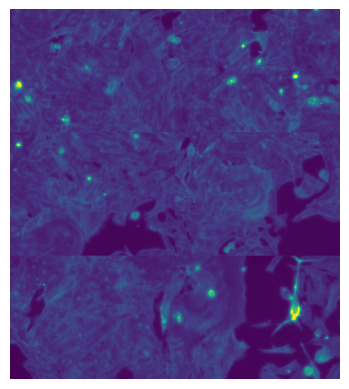

In [13]:


def stitch_images_to_grid(image_paths, grid_shape=(3, 2)):
    # Assuming all images have the same dimensions
    sample_img = Image.open(image_paths[0])
    img_width, img_height = sample_img.size
    
    # Determine the grid's total size
    grid_width = img_width * grid_shape[1]
    grid_height = img_height * grid_shape[0]
    
    # Create an empty array for the grid
    grid_array = np.zeros((grid_height, grid_width), dtype=np.uint16)
    
    # Load and place each image into the grid array
    for index, img_path in enumerate(image_paths):
        row = index // grid_shape[1]
        col = index % grid_shape[1]
        # Load the image and convert to numpy array
        img = Image.open(img_path)
        img_array = np.array(img)
        # Place the image in the correct position
        grid_array[row*img_height:(row+1)*img_height, col*img_width:(col+1)*img_width] = img_array
    
    return grid_array

# Example usage
image_directory = '../raw_data/plate_24277/Ph_golgi/24277-Ph_golgi'
well_id = 'a01'  # Update well_id as needed
image_paths = sorted(glob.glob(f'{image_directory}/*_{well_id}_*.tif'))

# Ensure you have exactly 6 images
if len(image_paths) != 6:
    print("Error: Expected 6 images for stitching.")
else:
    # Stitch images into a single array
    stitched_grid = stitch_images_to_grid(image_paths, grid_shape=(3, 2))
    
    # Display the stitched image with a mock color (colormap)
    plt.imshow(stitched_grid, cmap='viridis')  # You can change 'viridis' to any other colormap (e.g., 'plasma', 'magma', 'cividis')
    plt.axis('off')
    plt.show()

In [2]:
# Function to parse well information from filename
def parse_well_from_filename(filename):
    parts = filename.split('_')
    well = parts[1]  # Assuming the well identifier is always in this position
    return well

# Function to combine images
def combine_images(image_paths):
    images = [Image.open(img_path) for img_path in image_paths]
    # Assuming all images are of the same size, concatenate them horizontally (or vertically)
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    composite = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        composite.paste(im, (x_offset, 0))
        x_offset += im.size[0]
    return composite

# Assuming 'image_files' contains all image paths
well_to_images = {}
for image_path in image_files:
    well = parse_well_from_filename(os.path.basename(image_path))
    if well not in well_to_images:
        well_to_images[well] = []
    well_to_images[well].append(image_path)

# Combine images for each well into a composite image
composite_images = {well: stitch_images_to_grid(paths) for well, paths in well_to_images.items()}

NameError: name 'image_files' is not defined

In [ ]:
comp